# CMM262: Statistics, Day 3: RNA Expression Analysis Case Study

**Today's goal**: Learn how to create and understand commonly used plots in gene expression analysis.


## Case Study: Human Airway Smooth Muscle Transcriptome Changes in Response to Asthma Medications
> Paper: [Himes, Blanca E., et al. PloS one (2014)](https://pubmed.ncbi.nlm.nih.gov/24926665/)
>
> Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE52778

#### Rationale
Asthma is a chronic inflammatory airway disease. The most common medications used for its treatment are β2-agonists and glucocorticosteroids, and one of the primary tissues that these drugs target in the treatment of asthma is the airway smooth muscle. We used RNA-Seq to characterize the **human airway smooth muscle (HASM)** transcriptome at baseline and under three asthma treatment conditions.

## Table of Contents
1. Gene Expression Data
2. Gene Filtering
3. Total Reads per Sample
3. The Log Transformation
4. Clustering Analysis
    - Sample correlations
5. Principal Component Analysis
6. Differential Expression Concepts

# 1. Gene Expression Data

Gene expression data is commonly stored in a text file, stored as a table where each row is a gene and each column is a sample. In this case, the file at `data/asm_dex_counts.txt` contains our gene expression read counts, formatted as a tab-separated text file.

### Import Python packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Load read counts table

The first argument is the filepath while specifying `index_col='Name'` sets the 'Name' variable to the `DataFrame` index/row names.

In [2]:
counts = pd.read_table('data/asm_dex_counts.txt', index_col='Name')

You should see **8 samples** and **57,773 genes**.

<div class="alert alert-block alert-info">
    <b>Note:</b> Raw read counts will <b>always</b> be whole numbers! If you see anything otherwise in your table, you are dealing with read counts that have been <b>normalized</b> or <b>estimated</b>.
</div>

In [3]:
counts

,A,B,E,F,I,J,M,N
Name,,,,,,,,
ENSG00000000003,667,434,862,401,1133,1050,750,562
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,430,488,556,334,529,719,378,468
ENSG00000000457,256,226,276,174,288,358,248,235
ENSG00000000460,56,52,29,30,63,53,68,56
...,...,...,...,...,...,...,...,...
ENSG00000273487,3,4,0,9,6,4,3,8
ENSG00000273488,5,3,5,3,3,10,6,11
ENSG00000273489,0,0,0,2,1,0,0,0


### Load sample annotations

Additional information will almost always accompany gene expression data, which includes variables like experimental treatment conditions, batches, and sample names.

We can use the same function as we did for loading the gene expression table to load sample annotations from a text file. This time, we use `index_col='sample'` to set the 'sample' variable as the index/row names. The additional parameter `squeeze=True` loads the data as a `pd.Series` object.

In [4]:
labels = pd.read_table('data/asm_dex_labels.txt', index_col='sample', squeeze=True)

You should see 8 sample labels, labeled either `untreated` or `Dex`. Dexamethoasone is a corticosteriod drug used to treat asthma among many other inflammatory conditions).

In [5]:
labels

sample
A    untreated
B          Dex
E    untreated
F          Dex
I    untreated
J          Dex
M    untreated
N          Dex
Name: condition, dtype: object

# 2. Gene Filtering

It is good practice to first examine the read distribution across all genes. We can then remove the unexpressed/low expression genes since they will be largely uninformative in further analysis.

## Filter out low expression genes (< 10 reads)

We can simply take the sum of each row to count reads per gene.

In [6]:
# axis=1 tells sum() to sum each row
# Otherwise, counts.sum() defaults to sum each column.
counts.sum(axis=1) 

Name
ENSG00000000003    5859
ENSG00000000005       0
ENSG00000000419    3902
ENSG00000000457    2061
ENSG00000000460     407
                   ... 
ENSG00000273487      37
ENSG00000273488      46
ENSG00000273489       3
ENSG00000273492       1
ENSG00000273493       0
Length: 57773, dtype: int64

Identify genes with 10 or greater reads expressed using the `>= 10` expression.

In [7]:
counts.sum(axis=1) >= 10

Name
ENSG00000000003     True
ENSG00000000005    False
ENSG00000000419     True
ENSG00000000457     True
ENSG00000000460     True
                   ...  
ENSG00000273487     True
ENSG00000273488     True
ENSG00000273489    False
ENSG00000273492    False
ENSG00000273493    False
Length: 57773, dtype: bool

Subset `counts` for these genes with `>=10` reads. There should now be only **20,405 genes**.

In [8]:
counts = counts.loc[counts.sum(axis=1) >= 10]

In [9]:
counts

,A,B,E,F,I,J,M,N
Name,,,,,,,,
ENSG00000000003,667,434,862,401,1133,1050,750,562
ENSG00000000419,430,488,556,334,529,719,378,468
ENSG00000000457,256,226,276,174,288,358,248,235
ENSG00000000460,56,52,29,30,63,53,68,56
ENSG00000000971,2847,3159,5377,3724,5927,9567,4447,6873
...,...,...,...,...,...,...,...,...
ENSG00000273478,13,6,10,5,11,8,5,6
ENSG00000273483,4,1,0,2,3,3,1,4
ENSG00000273486,13,11,23,6,20,29,12,11


Let's save our sample names to a list for easy use later.

In [10]:
samples = counts.columns.tolist()

In [11]:
samples

['A', 'B', 'E', 'F', 'I', 'J', 'M', 'N']

Let's save our gene names to a list as well.

In [12]:
genes = counts.index.tolist()

This list is really long, let's just print the first 10.

In [13]:
genes[:10]

['ENSG00000000003',
 'ENSG00000000419',
 'ENSG00000000457',
 'ENSG00000000460',
 'ENSG00000000971',
 'ENSG00000001036',
 'ENSG00000001084',
 'ENSG00000001167',
 'ENSG00000001460',
 'ENSG00000001461']

# 3. Total Reads Per Sample

We can again use the `DataFrame.sum()` function to sum read counts, this time across columns (samples).

In [14]:
sample_counts = counts.sum()

A bar plot is an effective way to visualize a handful of samples. Put samples on the x-axis and sample read count on the y-axis.

Text(0, 0.5, 'Read counts')

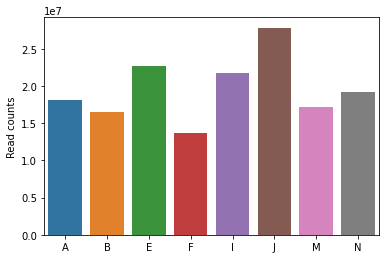

In [15]:
sns.barplot(x=samples, y=sample_counts)
plt.ylabel('Read counts') # Label the y-axis

We can color each sample's bar by treatment condition by setting `hue=labels`. We use`dodge=False` to format the bar widths (you can try it without it, not as pretty).

Text(0, 0.5, 'Read counts')

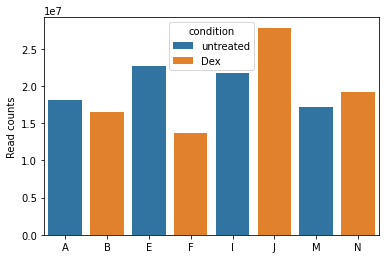

In [16]:
sns.barplot(x=samples, y=sample_counts, hue=labels, dodge=False)
plt.ylabel('Read counts') # Label the y-axis

---

# 4. The Log Transformation

Gene expression counts are not normally distributed, are usually heavily right skewed. This makes for some ugly unintuitive plots for raw counts. The log transformation (usually log base 2) helps to visualize things more meaninfully. Let's try visualizing before and after the log transformation.

## Raw gene count distributions

Let's plot a single sample `A` as a histogram. Notice how skewed the plot is.

<AxesSubplot:xlabel='A', ylabel='Count'>

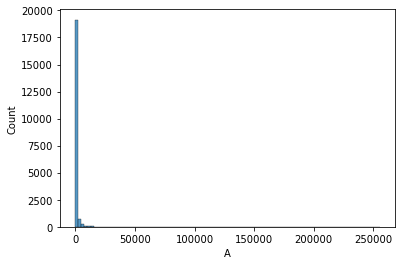

In [17]:
# Use 100 bins for our histogram
sns.histplot(data=counts['A'], bins=100)

Let's plot a boxplot for each sample. Notice how many points are outside the interquartile range (genes with really big counts).

<AxesSubplot:>

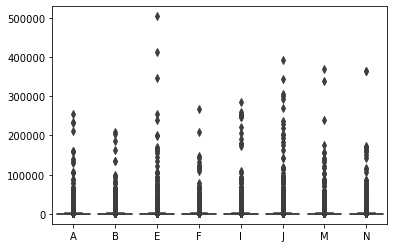

In [18]:
sns.boxplot(data=counts)

Now let's create a heatmap, where rows are genes and columns are samples. Notice how almost nothing is visible...

<AxesSubplot:ylabel='Name'>

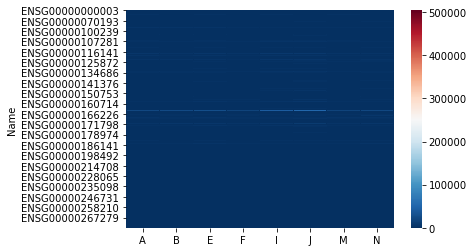

In [19]:
# We are using a color gradient called 'RdBu_r' which stands for 
# "red blue reversed" to code values in the heatmap.
# "Reversed" switches the direction of the gradient.
sns.heatmap(data=counts, cmap='RdBu_r')

## Log2 gene count distributions

Now let's take the log2 of the counts, which will force the data to look much more like a normal distribution. The full transformation we perform is $log_2(counts + 1)$.

The addition of `1` is commonly referred to as adding a **pseudocount**. This is usually a negligible amount added to all values to ensure all values are greater than 0, which allows us to apply a log transformation.

In [20]:
# Use the `np.log2()` function to apply log2 to every value in the counts DataFrame
log_counts = np.log2(counts+1)

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Let's plot the sample `A` as a histogram again. A roughly bell-shaped curve is now visible. This is what you  should expect a standard RNA-seq experiment to looks like.</p>
</div>



<div class="alert alert-block alert-info">
    <p><b>Note:</b> Next week we will go over why we can't make the assumption that gene expression is normally distributed. But for the purpose of this analysis, we will keep this simplified assumption for now.</p>
</div>

In [21]:
# TODO

<AxesSubplot:xlabel='A', ylabel='Count'>

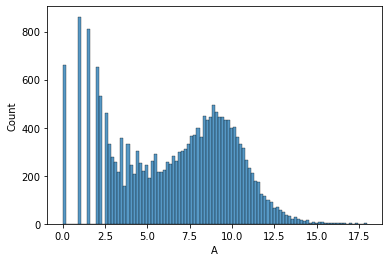

In [22]:
# Answer
sns.histplot(data=log_counts['A'], bins=100)

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Again, let's plot a boxplot for each sample. The quartiles should be clearly visible and the number of outliers have been greatly reduced thanks to the log transformation.</p>
</div>


In [23]:
# TODO

<AxesSubplot:>

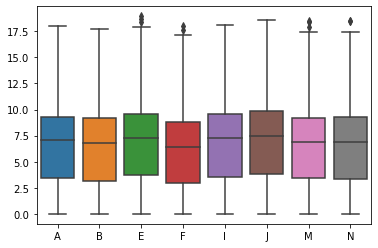

In [24]:
# Answer 
sns.boxplot(data=log_counts)

Violin plots are another very commonly used plot. It is a combination of a boxplot and density plot.

<AxesSubplot:>

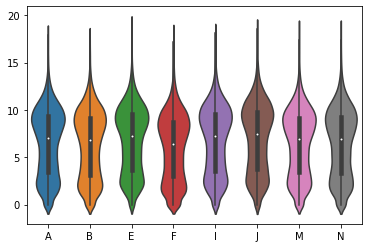

In [25]:
sns.violinplot(data=log_counts)

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Let's create a heatmap again; Now we can start to visually distinguish patterns between genes and samples.</p>
</div>



In [26]:
# TODO

<AxesSubplot:ylabel='Name'>

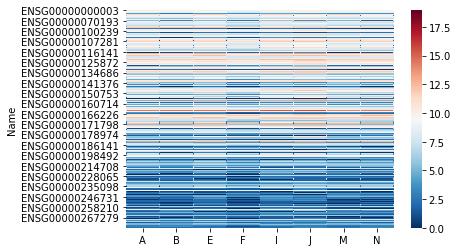

In [27]:
# Answer
sns.heatmap(data=log_counts, cmap='RdBu_r')

# Clustering Analysis

Heatmaps are an efficient way to visualize and compare values across genes and samples simultaneously. A common approach to clustering, or grouping values by similarity is **hierarchical clustering**. The `sns.clustermap()` function is an easy way to do cluster samples (columns) and genes (rows) for striking visualizations.

First lets cluster the rows. Notice how the rows have been reordered such that adjacent rows tend to have similar colors.

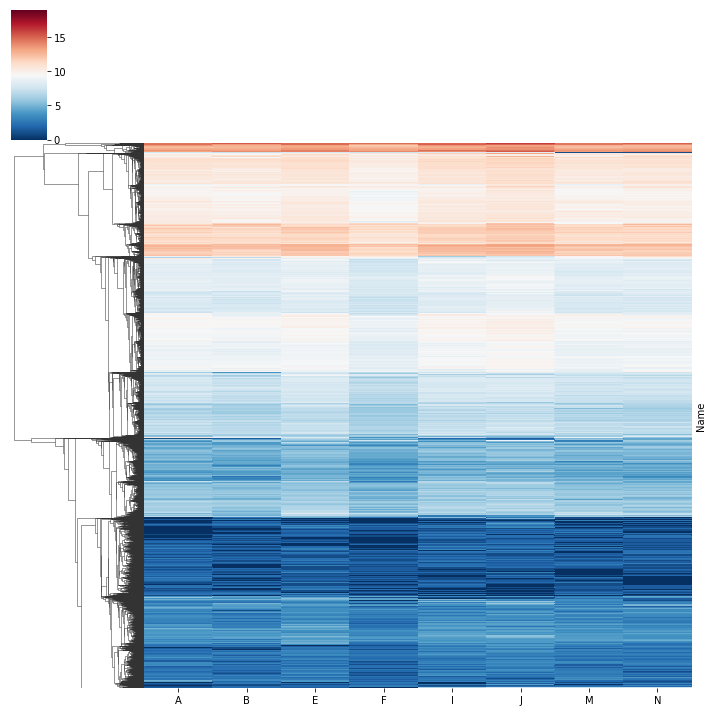

In [28]:
sns.clustermap(data=log_counts,
               col_cluster=False,
               row_cluster=True,
               xticklabels=True,
               yticklabels=False, # Hide row ticklabels, too many to view at once
               cmap='RdBu_r')

Now let's label the samples with the treatment condition.

In [29]:
# Get a color palette with seaborn. A palette is just a list of colors.
palette = sns.color_palette('tab10')

In [30]:
print(palette)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


Seaborn automagically displays the colors for us.

In [31]:
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

Now we're going to assign each unique condition a different color with the following line.

In [32]:
label2color = dict(zip(labels.unique(), palette))

The first argument of the `zip` command simply lists the unique condition values.

In [33]:
labels.unique()

array(['untreated', 'Dex'], dtype=object)

The nested `dict(zip())` command essentially turns the two lists (unique conditions and colors) into a single dictionary. Since the first argument is the unique conditions, these are the dictionary **keys** and the colors are the **values**.

In [34]:
dict(zip(labels.unique(), palette))

{'untreated': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Dex': (1.0, 0.4980392156862745, 0.054901960784313725)}

Finally, we will use the dictionary to assign each sample label its appropriate color.

In [35]:
# the map command looks up each sample's color in the dictionary we created
label_color = labels.map(label2color)

What is the point of all this? Now we can color each sample by its condition in the clustered heatmap.

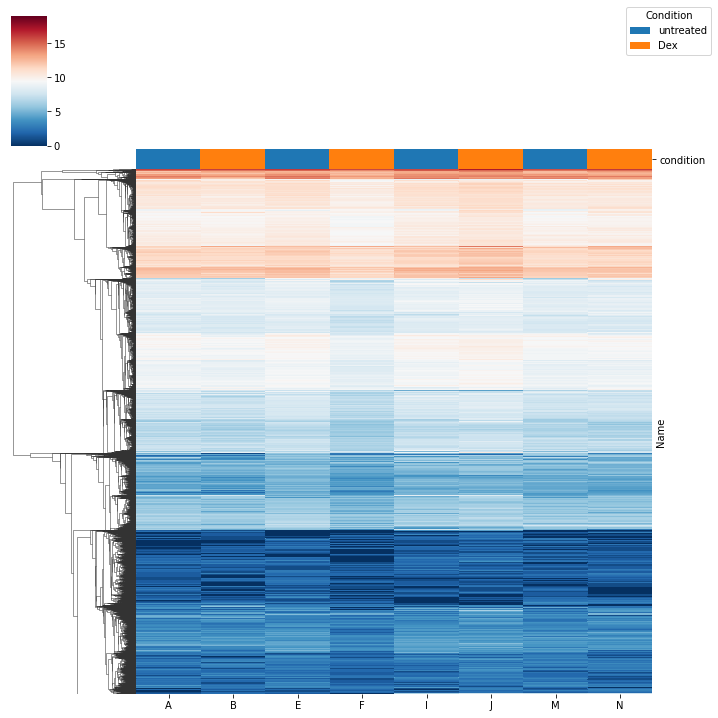

In [36]:
ax = sns.clustermap(data=log_counts,
                    col_cluster=False,
                    row_cluster=True,
                    xticklabels=True, 
                    yticklabels=False, # Hide row ticklabels, too many to view at once
                    col_colors=label_color, # Pass the colors we just assigned to each sample
                    cmap='RdBu_r')

# This creates the legend in the top right (ignore this for now)
from matplotlib.patches import Patch
handles = [Patch(facecolor=label2color[name]) for name in labels.unique()]
plt.legend(handles, label2color, title='Condition',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> In addition to clustering genes, cluster the samples as well. Start by copying the previous cell and changing the appropriate parameter to cluster columns.</p>
</div>

In [37]:
# TODO

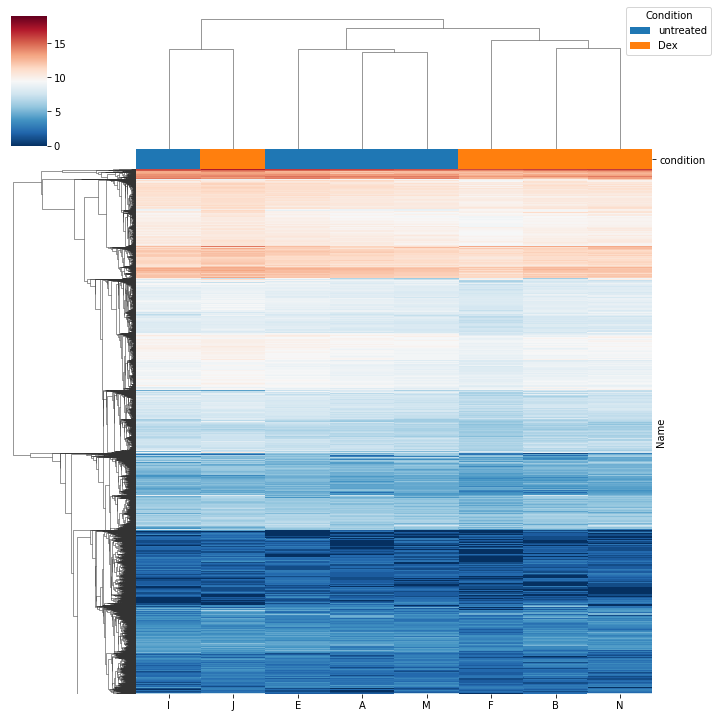

In [38]:
# Answer
ax = sns.clustermap(data=log_counts,
                    col_cluster=True,
                    row_cluster=True,
                    xticklabels=True,
                    yticklabels=False, # Hide row ticklabels, too many to view at once
                    col_colors=label_color, # Pass the colors we just assigned to each sample
                    cmap='RdBu_r')

# This creates the legend in the top right (ignore this for now)
from matplotlib.patches import Patch
handles = [Patch(facecolor=label2color[name]) for name in labels.unique()]
plt.legend(handles, label2color, title='Condition',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

Notice that samples mostly group by condition now. Give yourself a pat on the back! You've created quite a complex and informative figure. 

## Sample correlations

Scatter plots are useful to visualize the similarity/correlation between samples. Each point represents a gene. The higher the correlation, the more similar the two samples are.

<div class="alert alert-block alert-info">
    <p><b>Note:</b> We usually expect/hope to see this general trend when inspecting sample correlation: replicates > sample type > treatment condition.</p>
</div>

In [39]:
from scipy import stats

The correlation between sample `A` (untreated) vs sample `E` (dexamethasone) is `0.98`.

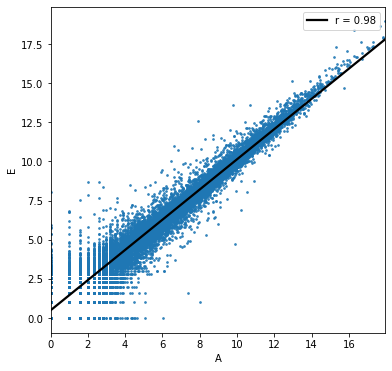

In [40]:
# Set the figure size to 6 x 6
plt.figure(figsize=(6,6))

# Scatter plot and Linear regression line fit to the data
sns.regplot(data=log_counts, # specify the DataFrame
            x='A', # plot sample A on the x-axis
            y='E', # plot sample E on the y-axis
            scatter_kws={'s': 3}, # set point size = 3px
            line_kws={'color': 'black'})  # set line color to black

r, p_value = stats.pearsonr(log_counts['A'], log_counts['E']) # calculate pearson correlation and p-value
plt.legend([f'r = {r:.2f}']) # Put correlation on legend, formatted to 2 decimal places

We can calculate all pairwise sample correlations with the `DataFrame.corr()` function. This calculates the correlation between **columns** by default.

In [41]:
counts.corr()

,A,B,E,F,I,J,M,N
A,1.000000,0.955797,0.934322,0.884870,0.944199,0.895099,0.959218,0.893904
B,0.955797,1.000000,0.923135,0.939672,0.908328,0.928354,0.932174,0.948371
E,0.934322,0.923135,1.000000,0.951668,0.922181,0.908162,0.978705,0.945762
F,0.884870,0.939672,0.951668,1.000000,0.863867,0.942422,0.928398,0.983220
I,0.944199,0.908328,0.922181,0.863867,1.000000,0.919564,0.920803,0.852122
J,0.895099,0.928354,0.908162,0.942422,0.919564,1.000000,0.885319,0.916882
M,0.959218,0.932174,0.978705,0.928398,0.920803,0.885319,1.000000,0.948565
N,0.893904,0.948371,0.945762,0.983220,0.852122,0.916882,0.948565,1.000000


<div class="alert alert-block alert-success">
    <p><b>Exercise:</b> Plot the sample correlation values in a heatmap. Cluster the rows and columns and plot the treatment condition colors like we did previously.</p>
</div>

In [42]:
# TODO

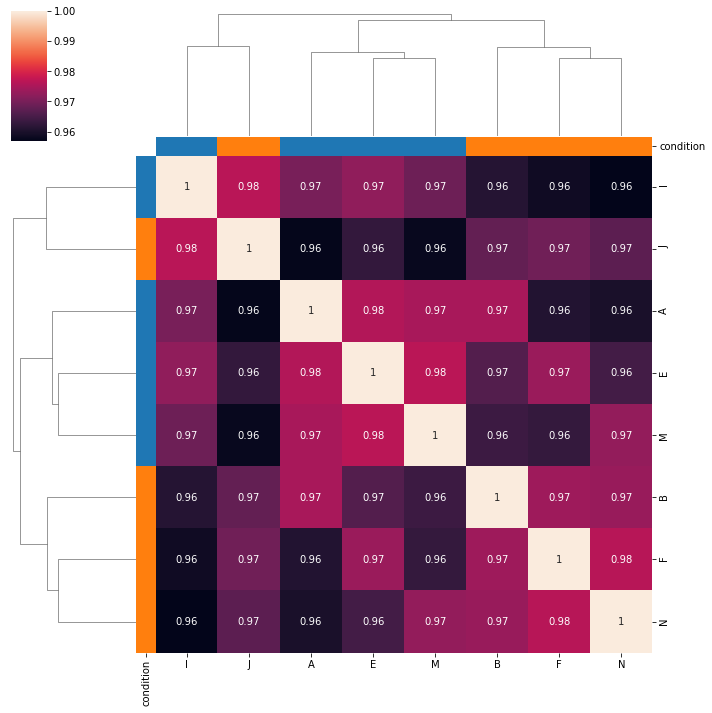

In [43]:
# ANSWER
sns.clustermap(log_counts.corr(), 
               col_cluster=True, # cluster columns
               row_cluster=True, # cluster rows
               col_colors=label_color, # Color samples by condition (columns)
               row_colors=label_color, # Color samples by condition (rows)
               annot=True)

# Principal Component Analysis

Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. PCA is a fundamental **dimensionality reduction** technique.

An amazing visual resource: https://setosa.io/ev/principal-component-analysis/

![Input and corresponding PCA output](img/day2_pca.png)

First import the PCA class from `sklearn`.

In [44]:
from sklearn.decomposition import PCA

The PCA analysis prefers to have samples as rows and features as columns. We can flip/transpose our `log_counts` DataFrame to match this requirement.

In [45]:
log_counts.T

Name,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,...,ENSG00000273456,ENSG00000273466,ENSG00000273472,ENSG00000273474,ENSG00000273477,ENSG00000273478,ENSG00000273483,ENSG00000273486,ENSG00000273487,ENSG00000273488
A,9.383704,8.751544,8.005625,5.832890,11.475733,11.057992,9.074141,8.738092,7.400879,11.046442,...,2.807355,2.807355,2.321928,1.584963,2.000000,3.807355,2.321928,3.807355,2.000000,2.584963
B,8.764872,8.933691,7.826548,5.727920,11.625709,10.574594,8.596190,8.011227,7.366322,10.868823,...,2.584963,3.000000,2.584963,0.000000,3.321928,2.807355,1.000000,3.584963,2.321928,2.000000
E,9.753217,9.121534,8.113742,4.906891,12.392854,11.264443,9.299208,8.974415,8.016808,12.353974,...,3.000000,3.169925,3.584963,2.000000,2.584963,3.459432,0.000000,4.584963,0.000000,2.584963
F,8.651052,8.388017,7.451211,4.954196,11.863025,10.274960,9.011227,7.491853,6.845490,11.403545,...,2.000000,2.807355,2.807355,1.000000,2.321928,2.584963,1.584963,2.807355,3.321928,2.000000
I,10.147205,9.049849,8.174926,6.000000,12.533330,10.999295,9.743151,9.453271,7.845490,11.451726,...,2.000000,3.584963,4.087463,1.584963,2.807355,3.584963,2.000000,4.392317,2.807355,2.000000
J,10.037547,9.491853,8.487840,5.754888,13.224002,10.995767,9.535275,9.250298,7.700440,11.450180,...,3.321928,3.700440,3.169925,0.000000,3.321928,3.169925,2.000000,4.906891,2.321928,3.459432
M,9.552669,8.566054,7.960002,6.108524,12.118941,10.913637,9.459432,8.584963,7.238405,11.294621,...,2.584963,3.169925,3.321928,0.000000,2.807355,2.584963,1.000000,3.700440,2.000000,2.807355
N,9.136991,8.873444,7.882643,5.832890,12.746934,10.641149,9.515700,8.139551,7.417853,11.536247,...,3.459432,3.700440,3.000000,2.000000,3.807355,2.807355,2.321928,3.584963,3.169925,3.584963


Now we can perform the transformation. Now, the samples live in **2D** space, instead of **20405D** space (# genes)!

In [46]:
# Create a PCA object and call the fit_transform function.
# Setting n_components=2 means only the first 2 components are calculated
principal_components = PCA(n_components=2).fit_transform(log_counts.T) 

Let's format this as a `DataFrame` for convenience.

In [47]:
principal_components = pd.DataFrame(principal_components)

Each column is a principal component (in this case, only the first 2 PCs).

In [48]:
principal_components

,0,1
0,-4.409583,-59.522507
1,43.084263,11.860775
2,-32.633861,-34.502991
3,90.240817,29.305239
4,-70.050254,-3.166961
5,-76.140642,72.872554
6,10.273982,-49.399729
7,39.635279,32.553620


## Plot samples in principal component space

<AxesSubplot:xlabel='0', ylabel='1'>

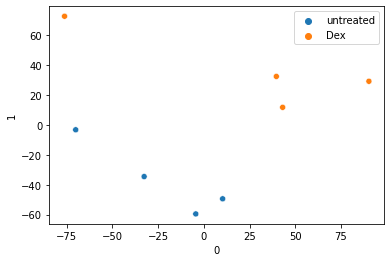

In [49]:
sns.scatterplot(x=principal_components[0],
                y=principal_components[1],
                hue=labels.values # color samples by treatment condition
               )

You should see untreated samples tend to be closer together, while Dexamethosone treated samples are closer together.

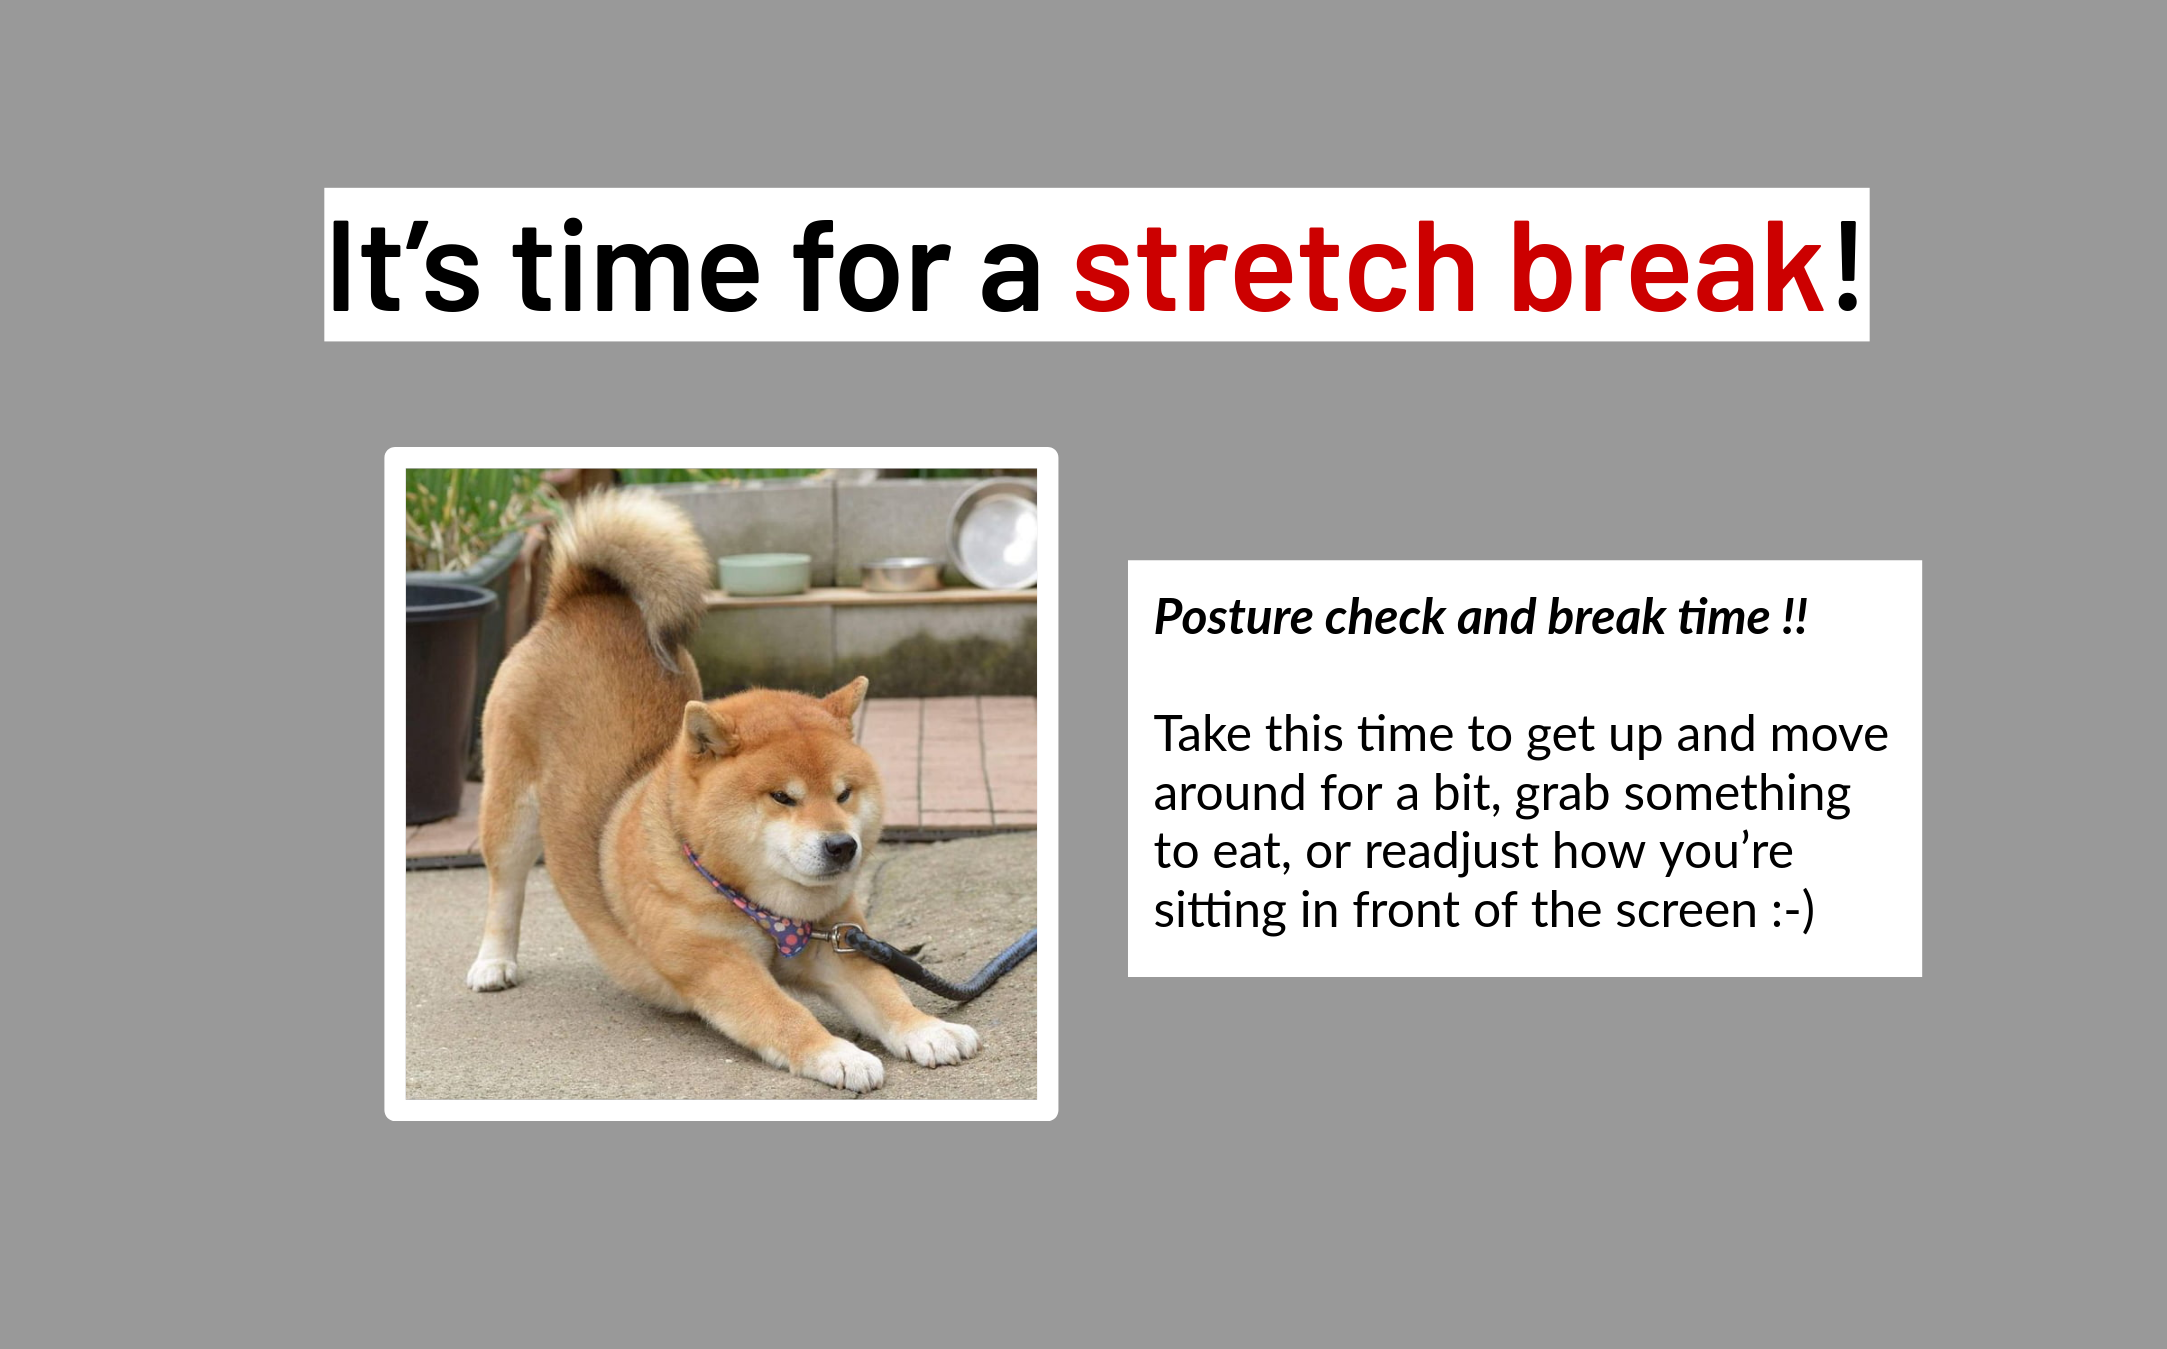

# 7. Differential Expression Concepts

What is differential expression analysis (DE)? It ultimately boils down to identifying a **statistically significant** change in expression between two conditions. For now, we will use the simplest model possible for DE analysis: **a two-sample t-test**.

We perform a t-test on the expression levels of each gene, comparing `Dexamethasone` to `untreated` samples.

<div class="alert alert-block alert-info">
    <p><b>Note:</b> We will be learning moure about <b>DESeq2</b>, a bioinformatics tool in R that is widely regarded as the gold standard for differential expression analysis. It uses the same concepts covered here, albeit using more appropriate statistical models (Negative Binomial distribution).</p>
</div>

Select the **untreated** samples.

In [50]:
untreated_counts = log_counts.loc[:,labels == 'untreated']

In [51]:
untreated_counts.head()

,A,E,I,M
Name,,,,
ENSG00000000003,9.383704,9.753217,10.147205,9.552669
ENSG00000000419,8.751544,9.121534,9.049849,8.566054
ENSG00000000457,8.005625,8.113742,8.174926,7.960002
ENSG00000000460,5.832890,4.906891,6.000000,6.108524
ENSG00000000971,11.475733,12.392854,12.533330,12.118941


Now select the **treated** samples.

In [52]:
dex_counts = log_counts.loc[:,labels == 'Dex']

In [53]:
dex_counts.head()

,B,F,J,N
Name,,,,
ENSG00000000003,8.764872,8.651052,10.037547,9.136991
ENSG00000000419,8.933691,8.388017,9.491853,8.873444
ENSG00000000457,7.826548,7.451211,8.487840,7.882643
ENSG00000000460,5.727920,4.954196,5.754888,5.832890
ENSG00000000971,11.625709,11.863025,13.224002,12.746934


Now perform a t-test **for each gene** (over 20,000 tests!).

In [54]:
ttest_results = stats.ttest_ind(dex_counts.T, untreated_counts.T) # perform t-test on each gene
ttest_results = pd.DataFrame(ttest_results).T # Format results as a DataFrame
ttest_results.columns = ['t_stat', 'p_value'] # Name the columns nicely
ttest_results.index = genes # Label row names with genes

In [55]:
ttest_results.head()

,t_stat,p_value
ENSG00000000003,-1.583447,0.164409
ENSG00000000419,0.190037,0.855546
ENSG00000000457,-0.688527,0.516844
ENSG00000000460,-0.421788,0.687874
ENSG00000000971,0.531243,0.614333


## Perform multiple testing correction

Because we are performing thousands of tests, many of our significant results will occur simply by chance. Multiple testing correction **reduces** the number of false positives in our data according to our defined significance threshold. We will use an `alpha = 0.05`.

In [56]:
from statsmodels.stats.multitest import multipletests

In [57]:
# Copy the t test results to a new DataFrame
diff_results = ttest_results.copy()

# Perform multiple testing correction on p-values
mult_test_results = multipletests(ttest_results['p_value'], alpha=0.05, method="fdr_bh")

# Save which genes pass significance threshold = 0.05
diff_results['significance'] = mult_test_results[0]

# Save corrected p-values
diff_results['p_corrected'] = mult_test_results[1]

# Save -log10(corrected p-values)
diff_results['-log10p_corrected'] = -np.log10(diff_results['p_corrected'])

## Calculate log2 fold change

Now that we have a list of differentially expressed genes, it is equally as important to check the **effect size**, or the magnitude of change.

Rather than the absolute difference, we typically use **log fold change** to measure changes in gene expression:
$$ log_2(\frac{\bar\mu_{treatment}}{\bar\mu_{control}}) $$

> Some helpful reminders about effect size:
>
> <img src="img/day3_effect_size.jpg" width="300"> <img src="img/day3_tiny_values.jpg" width="450">

In [58]:
# Calculate and save log2 fold change
diff_results['log2fc_dex'] = np.log2((dex_counts.mean(axis=1) + 1) / (untreated_counts.mean(axis=1) + 1))

In [59]:
#Sort rows by p-values
diff_results = diff_results.sort_values('p_value')

Let's preview everything we just calculated.

In [60]:
diff_results.head()

,t_stat,p_value,significance,p_corrected,-log10p_corrected,log2fc_dex
ENSG00000179593,21.243871,7.093209e-07,True,0.007529,2.123283,2.956889
ENSG00000255651,-21.102740,7.379225e-07,True,0.007529,2.123283,-0.760300
ENSG00000143125,18.275367,1.729037e-06,True,0.011760,1.929580,1.534181
ENSG00000152583,16.819226,2.821854e-06,True,0.012106,1.916984,0.682315
ENSG00000134253,-16.677051,2.966535e-06,True,0.012106,1.916984,-0.397408


### Visualize DE results

Volcano plots are a useful way to visualise the results of differential expression analyses. In an typical DE analysis, we expect to see a couple things:
- most genes are **not** significantly different
- there are roughly equal number of genes whose `log2fc > 0` and `log2fc < 0`

<AxesSubplot:xlabel='log2fc_dex', ylabel='-log10p_corrected'>

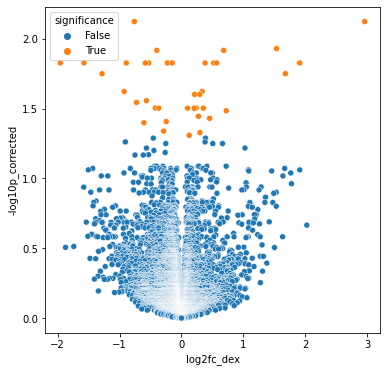

In [61]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=diff_results, x='log2fc_dex', y='-log10p_corrected', hue='significance')

## Are our results of our naive analysis real?

This study highlighted a number of interesting genes they concluded are important to Dexamethasone treatment. Let's see how many of those genes pop up in our DE results.

In [62]:
# DUSP1, KLF15, PER1, TSC22D3, C7, CCDC69, CRISPLD2
abstract_genes = ['ENSG00000120129', 'ENSG00000163884', 'ENSG00000179094', 'ENSG00000157514', 'ENSG00000112936', 'ENSG00000198624', 'ENSG00000103196']
abstract_genes = set(abstract_genes) # Make a set; all values in a set are unique

Retrieve the names of our DE significant genes.

In [63]:
sig_genes = diff_results.loc[diff_results['significance'] == True].index
sig_genes = set(sig_genes)

Import a method to make venn diagrams with `matplotlib`.

In [64]:
from matplotlib_venn import venn2

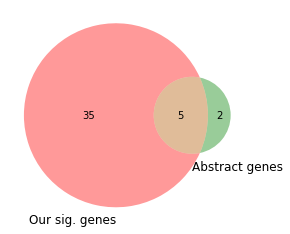

In [65]:
venn2([sig_genes, abstract_genes], set_labels=['Our sig. genes', 'Abstract genes'])

### What are our statistics for the study's interesting genes?

In [66]:
diff_results.loc[abstract_genes]

,t_stat,p_value,significance,p_corrected,-log10p_corrected,log2fc_dex
ENSG00000120129,11.612768,0.000025,True,0.023854,1.622446,0.334618
ENSG00000163884,10.156722,0.000053,True,0.032772,1.484491,0.722676
ENSG00000112936,3.681266,0.010315,False,0.262445,0.580962,0.407696
ENSG00000103196,11.337910,0.000028,True,0.025008,1.601922,0.296146
ENSG00000179094,9.835428,0.000064,True,0.037116,1.430443,0.455389
ENSG00000157514,8.990793,0.000106,False,0.051440,1.288696,0.387661
ENSG00000198624,10.437449,0.000045,True,0.031409,1.502945,0.353148
